<a href="https://colab.research.google.com/github/lsrodri/KneeOsteoarthritis/blob/main/notebooks/Custom_CNN_and_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning pre-processed data

In [1]:
!git clone https://github.com/lsrodri/KneeOsteoarthritis.git

Cloning into 'KneeOsteoarthritis'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28 (delta 6), reused 2 (delta 0), pack-reused 7 (from 2)
Receiving objects: 100% (28/28), 46.53 MiB | 42.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import os

if not os.path.exists('data'):
  os.makedirs('data')

!unzip -q KneeOsteoarthritis/data/processed_data.zip -d data/

# Import Libraries and Modules

Necessary libraries and modules for building and training a deep learning model using TensorFlow and Keras.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import (
      BatchNormalization,
      Conv2D,
      Dense,
      Dropout,
      Flatten,
      Lambda,
      MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception

# Normalization and Optimization

Applying a normalization function to the training and testing datasets using Keras's `Rescaling` layer. This is a common preprocessing step for image data to scale pixel values to a range between 0 and 1, which improves model training with numerically-safe features.

Additionally, the cell caches and prefetches the datasets for performance optimization. Caching keeps the dataset elements in memory after they've been loaded, so they don't need to be reloaded in subsequent epochs. Prefetching overlaps the data preprocessing and model execution, improving training speed.

In [4]:
train_folder = "data/processed_data/train"
validation_folder = "data/processed_data/validation"
test_folder = "data/processed_data/test"

img_height = 224
img_width = 224
batch_size = 32

train = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    verbose=False
)

validation = tf.keras.utils.image_dataset_from_directory(
    validation_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    verbose=False
)

test = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    verbose=False
)

# Class imbalances

Here, we plot the classes within training data to identify imbalances that can be fixed through augmentation:

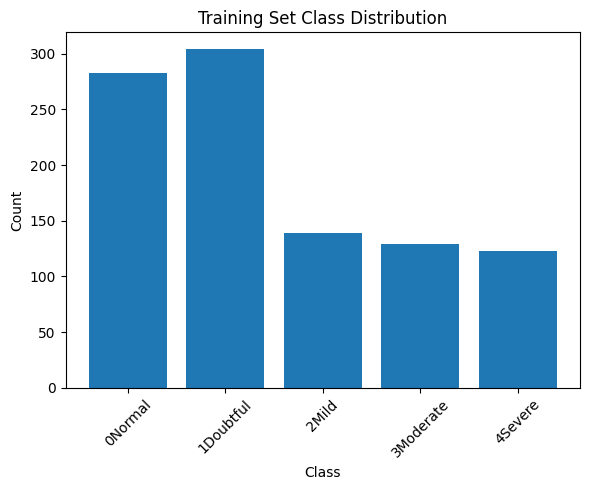

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

def get_class_distribution(dataset):
    labels = []
    for images, batch_labels in dataset:
        class_indices = np.argmax(batch_labels.numpy(), axis=1)
        labels.extend(class_indices)
    return np.unique(labels, return_counts=True)

train_classes, train_counts = get_class_distribution(train)

train_folder = "data/processed_data/train"
class_names = sorted(os.listdir(train_folder))

plt.figure(figsize=(6, 5))
plt.bar([class_names[i] for i in train_classes], train_counts)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Data augmentation

This cell addresses imbalances between classes in the training data and adds overall augmentation to the dataset. Augmentation improved test accuracy in around 10%

Generating 317 augmentations for class: 0Normal to reach 600
Found 283 images belonging to 1 classes.
Generating 296 augmentations for class: 1Doubtful to reach 600
Found 304 images belonging to 1 classes.
Generating 461 augmentations for class: 2Mild to reach 600
Found 139 images belonging to 1 classes.
Generating 471 augmentations for class: 3Moderate to reach 600
Found 129 images belonging to 1 classes.
Generating 477 augmentations for class: 4Severe to reach 600
Found 123 images belonging to 1 classes.
Augmentation process completed.


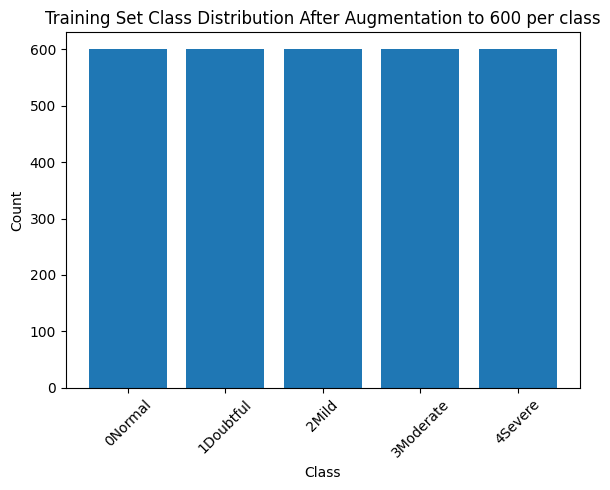

Total number of images in the augmented training set: 3000


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

target_count = 600

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    zoom_range=[0.9, 1.0],
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
)

for i, class_count in enumerate(train_counts):
    class_name = class_names[i]
    class_folder = os.path.join(train_folder, class_name)

    augmentations_needed = target_count - class_count

    if augmentations_needed > 0 and class_count < target_count:
        print(f"Generating {augmentations_needed} augmentations for class: {class_name} to reach {target_count}")

        class_generator = datagen.flow_from_directory(
            train_folder,
            classes=[class_name],
            target_size=(img_height, img_width),
            batch_size=1,
            save_to_dir=class_folder,
            save_prefix='aug',
            save_format='png',
            seed=42,
            interpolation='nearest',
            shuffle=False
        )

        for _ in range(augmentations_needed):
            try:
                next(class_generator)
            except Exception as e:
                print(f"Error generating augmentation for class {class_name}: {e}")


print("Augmentation process completed.")

train_augmented = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    verbose=False
)

train_classes_augmented, train_counts_augmented = get_class_distribution(train_augmented)

plt.figure(figsize=(6, 5))
plt.bar([class_names[i] for i in train_classes_augmented], train_counts_augmented)
plt.title(f'Training Set Class Distribution After Augmentation to {target_count} per class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

train = train_augmented

print(f"Total number of images in the augmented training set: {sum(train_counts_augmented)}")

# Normalization and Dataset Optimization

`normalization` uses Keras'  `Rescaling` layer to scale the pixel values of images to the range \[0, 1]. This normalization step is applied to both the training and testing datasets using the `.map()` function.

Additionally, the datasets are optimized for performance using `.cache()` and `.prefetch(buffer_size=AUTOTUNE)`.
-   `.cache()` keeps the dataset elements in memory after the first epoch, avoiding redundant loading.
-   `.prefetch()` overlaps the data preprocessing and model execution, improving training efficiency by ensuring data is ready when the model needs it.

In [7]:
# Normalization function using Rescaling layer
def normalization(image, label):
  rescale = tf.keras.layers.Rescaling(1./255)
  return rescale(image), label

# Apply normalization to the datasets
train = train.map(normalization)
validation = validation.map(normalization)
test = test.map(normalization)

# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
HEIGHT = 224
WIDTH = 224
CLASSES = 5
INPUT_SHAPE = (HEIGHT, WIDTH, 3)

In [9]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


# Hyperparameter Tuning with Keras Tuner

Performs Bayesian Optimization to find the best hyperparameters for the CNN model. It defines the model building function and configures the tuner to search for optimal values for filter sizes, dense layer units, dropout rates, optimizer, and learning rate.

In [ ]:
HYPERPARAMETER_TUNING = False #@param {type:"boolean"}

In [ ]:
if HYPERPARAMETER_TUNING:
  import kerastuner as kt
  from tensorflow import keras
  from tensorflow.keras import layers
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
  from tensorflow.keras.optimizers import Adam

  # Define the function to build the model with hyperparameters
  def build_cnn_model(hp):
      model = Sequential()

      # Hyperparameters for convolutional layers
      hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
      hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
      hp_filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)

      model.add(Conv2D(filters=hp_filters_1, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      model.add(Conv2D(filters=hp_filters_2, kernel_size=(3, 3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      model.add(Conv2D(filters=hp_filters_3, kernel_size=(3, 3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      model.add(Flatten())

      hp_units_1 = hp.Int('units_1', min_value=256, max_value=1024, step=256)
      hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)

      model.add(Dense(units=hp_units_1, activation='relu'))

      hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
      model.add(Dropout(hp_dropout_1))

      model.add(Dense(units=hp_units_2, activation='relu'))
      hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
      model.add(Dropout(hp_dropout_2))

      model.add(Dense(units=CLASSES, activation='softmax'))

      hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      if hp_optimizer == 'adam':
          optimizer = Adam(learning_rate=hp_learning_rate)
      else:
          optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)


      model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      return model

  tuner = kt.BayesianOptimization(
      build_cnn_model,
      objective="val_accuracy",
      max_trials=10,
      executions_per_trial=2,
      directory="knee_osteoarthritis_kt",
      project_name="cnn_tuning",
      overwrite=True,
      max_consecutive_failed_trials=5
  )

  tuner.search_space_summary()

  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  tuner.search(train,
              validation_data=validation,
              epochs=10,
              callbacks=[early_stopping])

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The optimal number of filters in the first conv layer is {best_hps.get('filters_1')}.
  The optimal number of filters in the second conv layer is {best_hps.get('filters_2')}.
  The optimal number of filters in the third conv layer is {best_hps.get('filters_3')}.
  The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
  The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
  The optimal dropout rate for the first dense layer is {best_hps.get('dropout_1')}.
  The optimal dropout rate for the second dense layer is {best_hps.get('dropout_2')}.
  The optimal optimizer is {best_hps.get('optimizer')}.
  The optimal learning rate is {best_hps.get('learning_rate')}.
  """)

  best_model = tuner.get_best_models(num_models=1)[0]

  loss, accuracy = best_model.evaluate(test)
  print(f"Best model loss: {loss:.4f}, accuracy: {accuracy:.4f}")

# Clearing memory before creating optimized model

My environment was throwing 'out of memory' errors, so I created the cell below to clear memory after hyperparameter tuning

In [ ]:
if HYPERPARAMETER_TUNING:
  import gc
  from tensorflow.keras import backend as K

  # Clear Keras session
  K.clear_session()

  # Force garbage collection
  gc.collect()

  # Check if model exists
  if 'model' in locals():
    del model
  elif 'model' in globals():
    del model


# Model with optimal hyperparameters

Creating the model with hyperparameters optimized with  Bayesian Optimization output



In [ ]:
# Check if the Bayesian Optimizer was run. Else, output previous values found to be best
best_hps_available = 'best_hps' in locals() and best_hps is not None

optimal_filters_1 = best_hps.get('filters_1') if best_hps_available else 32
optimal_filters_2 = best_hps.get('filters_2') if best_hps_available else 96
optimal_filters_3 = best_hps.get('filters_3') if best_hps_available else 64
optimal_units_1 = best_hps.get('units_1') if best_hps_available else 768
optimal_units_2 = best_hps.get('units_2') if best_hps_available else 192
optimal_dropout_1 = best_hps.get('dropout_1') if best_hps_available else 0.3
optimal_dropout_2 = best_hps.get('dropout_2') if best_hps_available else 0.1
optimal_optimizer = best_hps.get('optimizer') if best_hps_available else 'adam'
optimal_learning_rate = best_hps.get('learning_rate') if best_hps_available else 0.0001

model = Sequential([
    Conv2D(filters=optimal_filters_1, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=optimal_filters_2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=optimal_filters_3, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=optimal_units_1, activation='relu'),
    Dropout(optimal_dropout_1),
    Dense(units=optimal_units_2, activation='relu'),
    Dropout(optimal_dropout_2),
    Dense(units=CLASSES, activation='softmax')
])

optimal_learning_rate = optimal_learning_rate

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

optimizer = Adam(learning_rate=optimal_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the Model

Trains the CNN model using the prepared training data. It specifies the validation data for monitoring performance during training, sets the number of epochs and batch size, and includes the early stopping callback to prevent overfitting.

In [ ]:
history = model.fit(
    train,
    validation_data=validation,
    epochs = 30,
    batch_size = 8,
    callbacks = early_stopping,
    verbose = 1
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

# Xception Model

As my custom CNN had only performed at around 60% accuracy, I used the Xception model for transfer learning.

In [ ]:
if HYPERPARAMETER_TUNING:
  import kerastuner as kt
  from tensorflow import keras
  from tensorflow.keras import layers
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.callbacks import EarlyStopping
  from tensorflow.keras.applications import Xception

  def build_xception_model(hp):
      pretrained_model = Xception(
          include_top=False,
          input_shape=INPUT_SHAPE,
          weights='imagenet'
      )

      for layer in pretrained_model.layers:
          layer.trainable = False

      model = Sequential()
      model.add(pretrained_model)

      model.add(layers.GlobalAveragePooling2D())

      hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=128)
      hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)
      hp_units_3 = hp.Int('units_3', min_value=32, max_value=128, step=32)

      model.add(layers.Dense(units=hp_units_1, activation='relu'))

      hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
      model.add(layers.Dropout(hp_dropout_1))

      model.add(layers.Dense(units=hp_units_2, activation='relu'))
      hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
      model.add(layers.Dropout(hp_dropout_2))

      model.add(layers.Dense(units=hp_units_3, activation='relu'))
      hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)
      model.add(layers.Dropout(hp_dropout_3))

      model.add(layers.Dense(units=CLASSES, activation='softmax'))

      hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])

      optimizer = Adam(learning_rate=hp_learning_rate)

      model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

      return model

  tuner = kt.BayesianOptimization(
      build_xception_model,
      objective="val_accuracy",
      max_trials=10,
      executions_per_trial=2,
      directory="xception_tuning",
      project_name="xception_hyperparameter_tuning",
      overwrite=True,
      max_consecutive_failed_trials=5
  )

  tuner.search_space_summary()

  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  tuner.search(train,
              validation_data=validation,
              epochs=50,
              callbacks=[early_stopping])

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
  The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
  The optimal number of units in the third dense layer is {best_hps.get('units_3')}.
  The optimal dropout rate for the first dense layer is {best_hps.get('dropout_1')}.
  The optimal dropout rate for the second dense layer is {best_hps.get('dropout_2')}.
  The optimal dropout rate for the third dense layer is {best_hps.get('dropout_3')}.
  The optimal learning rate is {best_hps.get('learning_rate')}.
  """)

  best_model = tuner.get_best_models(num_models=1)[0]

  loss, accuracy = best_model.evaluate(test)
  print(f"Best model loss: {loss:.4f}, accuracy: {accuracy:.4f}")

Trial 2 Complete [00h 16m 19s]
val_accuracy: 0.7323077023029327

Best val_accuracy So Far: 0.7323077023029327
Total elapsed time: 00h 45m 20s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |128               |units_1
128               |192               |units_2
32                |96                |units_3
0.5               |0.2               |dropout_1
0.5               |0.2               |dropout_2
0.1               |0.3               |dropout_3
0.0001            |0.0001            |learning_rate

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2161 - loss: 1.6616

#Running the Xception model

Executing the Xception model with partial hyperparameter results from the Bayesian optimization search results in 73% validation accuracy.

In [12]:
units_1 = 128
units_2 = 192
units_3 = 96
dropout_1 = 0.2
dropout_2 = 0.2
dropout_3 = 0.3
learning_rate = 0.0001

pretrained_model = Xception(
    include_top=False,
    input_shape=INPUT_SHAPE,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model = Xception(
    include_top=False,
    input_shape=INPUT_SHAPE,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(units_1, activation='relu'))
model.add(layers.Dropout(dropout_1))

model.add(layers.Dense(units_2, activation='relu'))
model.add(layers.Dropout(dropout_2))

model.add(layers.Dense(units_3, activation='relu'))
model.add(layers.Dropout(dropout_3))

model.add(layers.Dense(CLASSES, activation='softmax'))

optimizer = Adam(learning_rate=learning_rate)

early_stop = EarlyStopping(monitor='val_loss', patience=15)

model.compile(loss='categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,167,533 (80.75 MB)

 Trainable params: 306,053 (1.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
history = model.fit(
    train,
    validation_data=validation,
    epochs = 100,
    batch_size = 8,
    callbacks = early_stop,
    verbose = 1
)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 215ms/step - accuracy: 0.2772 - loss: 1.5888 - val_accuracy: 0.4769 - val_loss: 1.3873
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.4462 - loss: 1.3615 - val_accuracy: 0.5446 - val_loss: 1.1594
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.5028 - loss: 1.1780 - val_accuracy: 0.5662 - val_loss: 1.0682
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.5561 - loss: 1.0628 - val_accuracy: 0.6062 - val_loss: 1.0113
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.5795 - loss: 0.9921 - val_accuracy: 0.6123 - val_loss: 0.9664
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.6209 - loss: 0.9276 - val_accuracy: 0.6308 - val_loss: 0.9294
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.6526 - loss: 0.8711 - val_accuracy: 0.6431 - val_loss: 0.9080
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.6654 - loss: 0.8378 - 

In [14]:
loss, accuracy = model.evaluate(test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.7204 - loss: 0.8387
Test loss: 0.9572, Test accuracy: 0.7173
